In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
data = pd.read_csv('dataset_reformate.csv')

data

,pays,date,nombre_total,entree_mensuelle
0,Albanie,2014-02-01,1333,16.0
1,Allemagne,2014-02-01,306716,445.0
2,Andorre,2014-02-01,23,0.0
3,Autriche,2014-02-01,41225,-37.0
4,Bélarus,2014-02-01,1143,39.0
...,...,...,...,...
25795,Total Océanie,2024-10-01,4010,37.0
25796,Apatride,2024-10-01,1254,6.0
25797,Sans nationalité,2024-10-01,272,3.0
25798,Etat inconnu,2024-10-01,1089,2.0


In [10]:
pays = 'France'

#pays = 'Total Europe'

data['date'] = pd.to_datetime(data['date'])  # Conversion en datetime
germany_data = data[data['pays'] == pays].sort_values(by='date')
germany_data

,pays,date,nombre_total,entree_mensuelle
14,France,2014-02-01,115383,720.0
214,France,2014-03-01,115826,443.0
414,France,2014-04-01,115734,-92.0
614,France,2014-05-01,116063,329.0
814,France,2014-06-01,116091,28.0
...,...,...,...,...
24814,France,2024-06-01,172630,18.0
25014,France,2024-07-01,173169,539.0
25214,France,2024-08-01,173836,667.0
25414,France,2024-09-01,174487,651.0


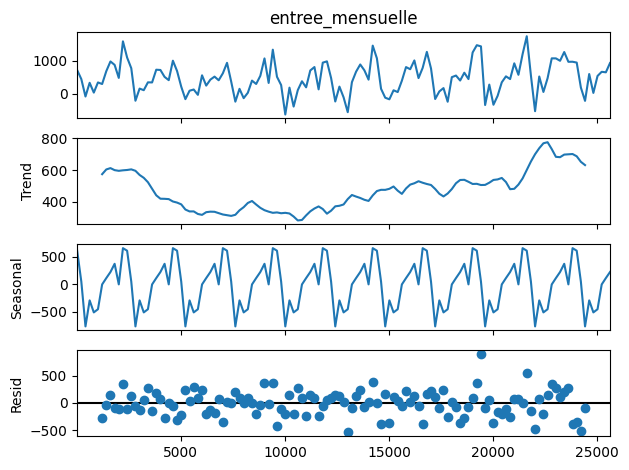

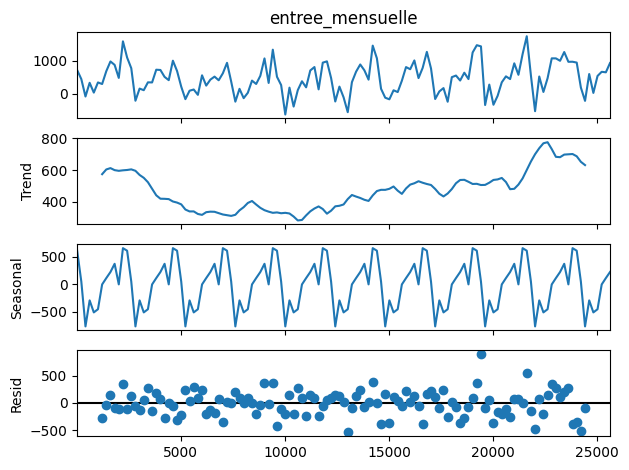

In [11]:
# Seasonal decomposition
decomposed = seasonal_decompose(germany_data['entree_mensuelle'], model='additive', period=12)
decomposed.plot()

In [12]:
germany_data['trend'] = decomposed.trend
germany_data['seasonal'] = decomposed.seasonal
germany_data['residual'] = decomposed.resid

germany_data['trend'].fillna(method='bfill', inplace=True)
germany_data['seasonal'].fillna(method='bfill', inplace=True)
germany_data['residual'].fillna(method='bfill', inplace=True)

C:\Users\Altin\AppData\Local\Temp\ipykernel_26860\1491477326.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  germany_data['trend'].fillna(method='bfill', inplace=True)
C:\Users\Altin\AppData\Local\Temp\ipykernel_26860\1491477326.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  germany_data['trend'].fillna(method='bfill', inplace=True)
C:\Users\Altin\AppData\Local\Temp\ipykernel_26860\1491477326.py:6: FutureWarning: A value is trying

In [13]:
# Paramètres de séquences temporelles
sequence_length = 12*2  # Utiliser les 12 derniers mois pour prédire le suivant

# Extraire la variable cible
#values = germany_data['entree_mensuelle'].values.reshape(-1, 1)

# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_values = scaler.fit_transform(germany_data[['entree_mensuelle', 'trend', 'seasonal', 'residual']])

# Créer les séquences temporelles
X, y = [], []
for i in range(len(normalized_values) - sequence_length):
    X.append(normalized_values[i:i + sequence_length])
    y.append(normalized_values[i + sequence_length][0])

X, y = np.array(X), np.array(y)

# Diviser en ensembles d'entraînement et de test janvier 2008- décembre 2022 pour l'entraînement et janvier 2023 - octobre 2024 pour le test
X_train, X_test, y_train, y_test = X[:len(X) - 22], X[len(X) - 22:], y[:len(y) - 22], y[len(y) - 22:]

# Formes des ensembles
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((83, 24, 4), (22, 24, 4), (83,), (22,))

In [14]:
# Modèle amélioré avec deux couches LSTM, Dropout, et un ReduceLROnPlateau pour ajuster le taux d'apprentissage
model = Sequential([
    Bidirectional(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compiler le modèle avec un optimiseur Adam et un taux d'apprentissage initial
model.compile(optimizer='adam', loss='mean_squared_error')

# Utiliser ReduceLROnPlateau pour ajuster le taux d'apprentissage si la perte de validation n'améliore pas
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2, verbose=1, callbacks=[reduce_lr])

c:\HES-SO\TSM-AnSeqDa\TSM-AnSeqDa\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


KeyboardInterrupt: 

In [ ]:
# Prédire les données de test
predicted_values = model.predict(X_test)

# Inverser la normalisation
#predicted_values = scaler.inverse_transform(predicted_values)
predicted_values = scaler.inverse_transform(np.hstack([predicted_values, np.zeros((predicted_values.shape[0], 3))]))[:, 0]
#y_test = scaler.inverse_transform(y_test)
y_test = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))]))[:, 0]

# Visualiser les résultats
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valeurs réelles')
plt.plot(predicted_values, label='Prédictions')
plt.legend()
plt.show()

# Calculer l'erreur quadratique moyenne
mse = np.mean(np.square(y_test - predicted_values))
mse

In [ ]:
test = data[data['pays'] == pays].sort_values(by='date')

plt.figure(figsize=(14, 7))
plt.plot(test['date'], test['entree_mensuelle'], label='Valeurs réelles')
plt.plot(test['date'].iloc[-len(y_test):], predicted_values, label='Prédictions')
plt.legend()
plt.show()

In [ ]:
# Nombre de mois à prédire
n_months_to_predict = 12 * 4

# Dernière séquence des données d'entraînement
#last_sequence = normalized_values[-sequence_length:].reshape(1, sequence_length, 1)
last_sequence = scaled_values[-sequence_length:].reshape(1, sequence_length, 4)

# Liste pour stocker les prédictions
future_predictions = []

for _ in range(n_months_to_predict):
    # Prédire le prochain mois
    next_value = model.predict(last_sequence)
    
    # Ajouter la prédiction à la liste
    future_predictions.append(next_value[0, 0])
    
    # Mettre à jour la séquence
    last_sequence = np.roll(last_sequence, -1, axis=1)

# Inverser la normalisation des prédictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Définir la date de début des prédictions (novembre 2024)
start_date = pd.Timestamp('2024-11-01')

# Créer une plage de dates pour les prédictions futures à partir de novembre 2024
future_dates = pd.date_range(start=start_date, periods=n_months_to_predict, freq='ME')

# Visualiser les prédictions futures
plt.figure(figsize=(14, 7))
plt.plot(germany_data['date'], germany_data['entree_mensuelle'], label='Valeurs réelles')
plt.plot(future_dates, future_predictions, label='Prédictions futures', linestyle='--')
# Ligne verticale pour séparer les données d'entraînement et de test
plt.axvline(x=germany_data['date'].iloc[-1], color='r', linestyle='--', linewidth=1)
plt.legend()
plt.title('Prédictions pour les prochains mois')
plt.show()

Epoch 1/50


C:\Users\Altin\AppData\Local\Temp\ipykernel_26860\1296832124.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  germany_data['trend'].fillna(0, inplace=True)
C:\Users\Altin\AppData\Local\Temp\ipykernel_26860\1296832124.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - loss: 0.1402 - val_loss: 0.1638 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0434 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0402 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0321 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0296 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0267 - val_loss: 0.0259 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0205 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0229 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0211 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/st

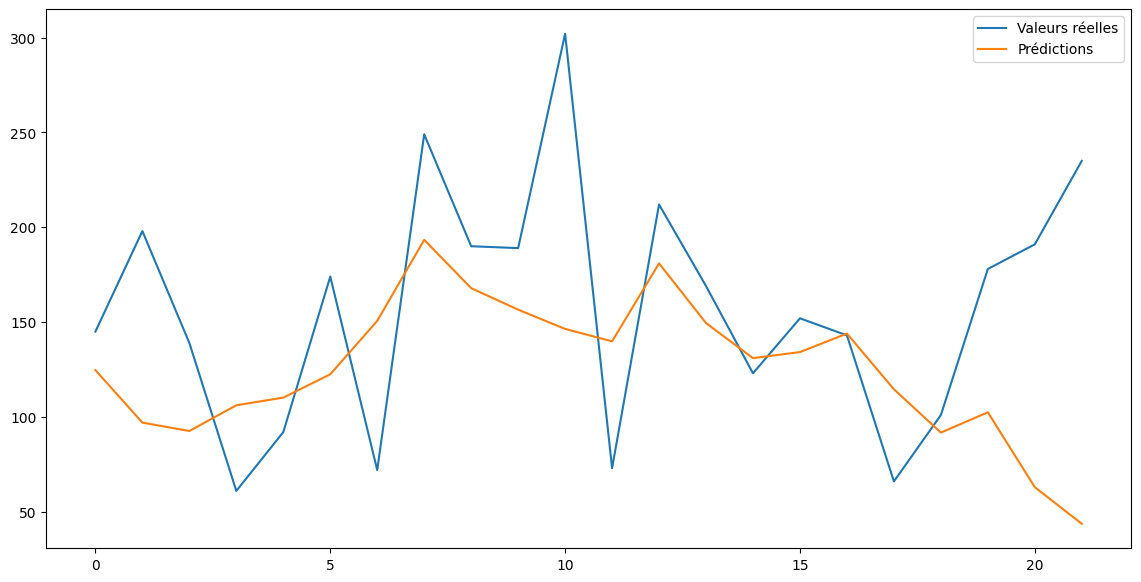

MSE:  5462.231019983656


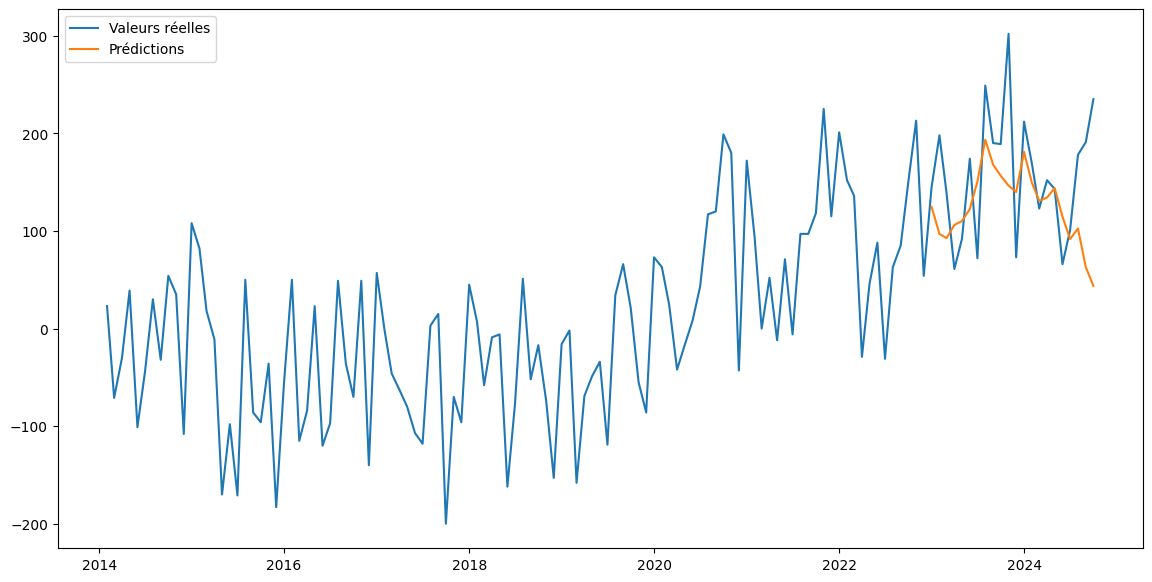

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


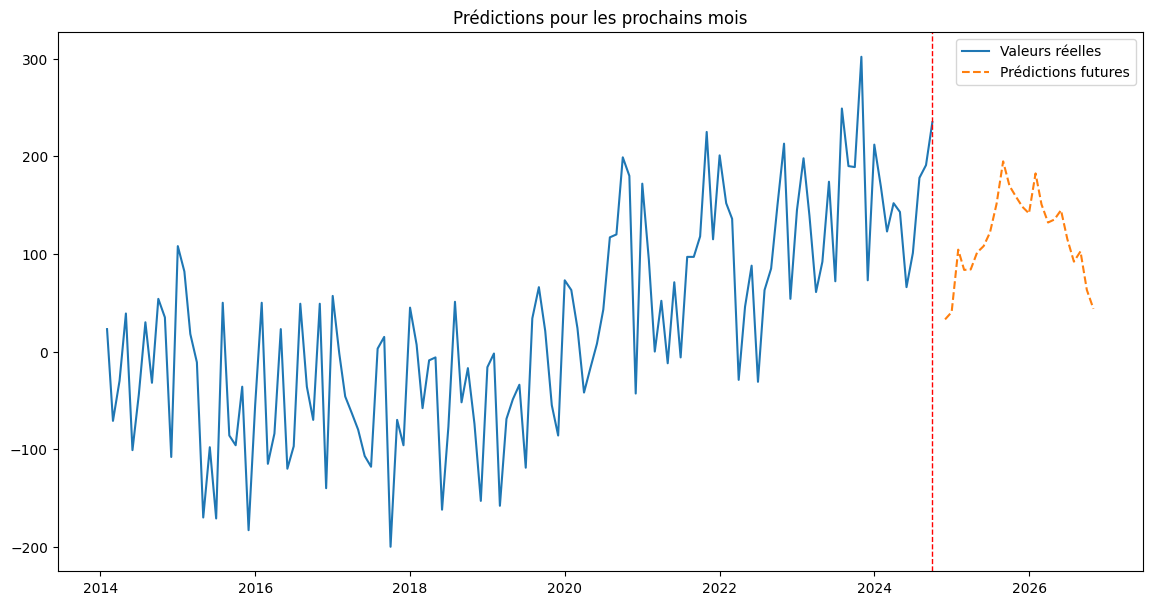

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Charger les données
data = pd.read_csv('dataset_reformate.csv')

pays = 'Turquie'

data['date'] = pd.to_datetime(data['date'])  # Conversion en datetime
germany_data = data[data['pays'] == pays].sort_values(by='date')

# Paramètres de séquences temporelles
sequence_length = 12 * 2  # Utiliser les 12 derniers mois pour prédire le suivant

# Extraire la variable cible
values = germany_data['entree_mensuelle'].values

# Décomposition saisonnière pour extraire la tendance et la saisonnalité
# On peut utiliser un modèle multiplicatif ou additif selon les données
decomposed = seasonal_decompose(germany_data['entree_mensuelle'], model='additive', period=12)

# Extraire les composants de la décomposition
germany_data['trend'] = decomposed.trend
germany_data['seasonal'] = decomposed.seasonal
germany_data['residual'] = decomposed.resid

# Remplacer les valeurs NaN dans la tendance par 0
germany_data['trend'].fillna(0, inplace=True)
germany_data['seasonal'].fillna(0, inplace=True)
germany_data['residual'].fillna(0, inplace=True)

# Normaliser les données
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalisation des données d'entrée avec les tendances et saisonnalités
scaled_values = scaler.fit_transform(germany_data[['entree_mensuelle', 'trend', 'seasonal', 'residual']])

# Créer les séquences temporelles
X, y = [], []
for i in range(len(scaled_values) - sequence_length):
    X.append(scaled_values[i:i + sequence_length])
    y.append(scaled_values[i + sequence_length][0])  # La variable cible est 'entree_mensuelle'

X, y = np.array(X), np.array(y)

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = X[:len(X) - 22], X[len(X) - 22:], y[:len(y) - 22], y[len(y) - 22:]

# Modèle amélioré avec deux couches LSTM, Dropout, et un ReduceLROnPlateau pour ajuster le taux d'apprentissage
model = Sequential([
    Bidirectional(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compiler le modèle avec un optimiseur Adam et un taux d'apprentissage initial
model.compile(optimizer='adam', loss='mean_squared_error')

# Utiliser ReduceLROnPlateau pour ajuster le taux d'apprentissage si la perte de validation n'améliore pas
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1, callbacks=[reduce_lr])

# Prédire les données de test
predicted_values = model.predict(X_test)

# Inverser la normalisation des prédictions
predicted_values = scaler.inverse_transform(np.hstack([predicted_values, np.zeros((predicted_values.shape[0], 3))]))[:, 0]
y_test = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))]))[:, 0]

# Visualiser les résultats
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Valeurs réelles')
plt.plot(predicted_values, label='Prédictions')
plt.legend()
plt.show()

# Calculer l'erreur quadratique moyenne
mse = np.mean(np.square(y_test - predicted_values))
print("MSE: ", mse)

# Visualiser les résultats avec les dates
test = data[data['pays'] == pays].sort_values(by='date')

plt.figure(figsize=(14, 7))
plt.plot(test['date'], test['entree_mensuelle'], label='Valeurs réelles')
plt.plot(test['date'].iloc[-len(y_test):], predicted_values, label='Prédictions')
plt.legend()
plt.show()

# Nombre de mois à prédire
n_months_to_predict = 12*2

# Dernière séquence des données d'entraînement
last_sequence = scaled_values[-sequence_length:].reshape(1, sequence_length, 4)  # 4 car on a 4 features

# Liste pour stocker les prédictions
future_predictions = []

for _ in range(n_months_to_predict):
    # Prédire le prochain mois
    next_value = model.predict(last_sequence)
    
    # Ajouter la prédiction à la liste
    future_predictions.append(next_value[0, 0])
    
    # Mettre à jour la séquence
    last_sequence = np.roll(last_sequence, -1, axis=1)

# Inverser la normalisation des prédictions
# Ajouter des colonnes factices (trend, seasonal, residual) avec des valeurs nulles
future_predictions_with_fakes = np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), 3))])

# Inverser la normalisation en utilisant le scaler qui a été ajusté avec 4 caractéristiques
future_predictions = scaler.inverse_transform(future_predictions_with_fakes)[:, 0]

# Définir la date de début des prédictions (novembre 2024)
start_date = pd.Timestamp('2024-11-01')

# Créer une plage de dates pour les prédictions futures à partir de novembre 2024
future_dates = pd.date_range(start=start_date, periods=n_months_to_predict, freq='ME')

# Visualiser les prédictions futures
plt.figure(figsize=(14, 7))
plt.plot(germany_data['date'], germany_data['entree_mensuelle'], label='Valeurs réelles')
plt.plot(future_dates, future_predictions, label='Prédictions futures', linestyle='--')
plt.axvline(x=germany_data['date'].iloc[-1], color='r', linestyle='--', linewidth=1)
plt.legend()
plt.title('Prédictions pour les prochains mois')
plt.show()

